## 2 Body perturbative
$$\mathcal{H} = \frac{|p|^2}{2m}+\frac{\gamma}{|q|}+ s \cos(\omega t)$$

In [1]:
import torch, time, sys
import autograd
import autograd.numpy as np
import numpy as nump
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-2bodypert'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_trajectory, dynamics_fn, hamiltonian_fn #, kofmotion #, k2_fn
from nn_models import MLP
from hnn import HNN_timedep
from utils import L2_loss

plt.style.use('fast') #alt: 'seaborn-white'

#plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['mathtext.fontset'] = "cm"
plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 6,
         'hidden_dim': 500,
         'learn_rate': 1e-3,
         'nonlinearity': 'snake',
         'total_steps': 2000,
         'field_type': 'contact',
         'print_every': 200,
         'name': '2bodypert',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'hamint': False,
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

In [3]:
def init_ecc(e):
    v = np.array([0.,np.sqrt((1.+e)/(1.-e)),1. - e, 0.0])
    return v

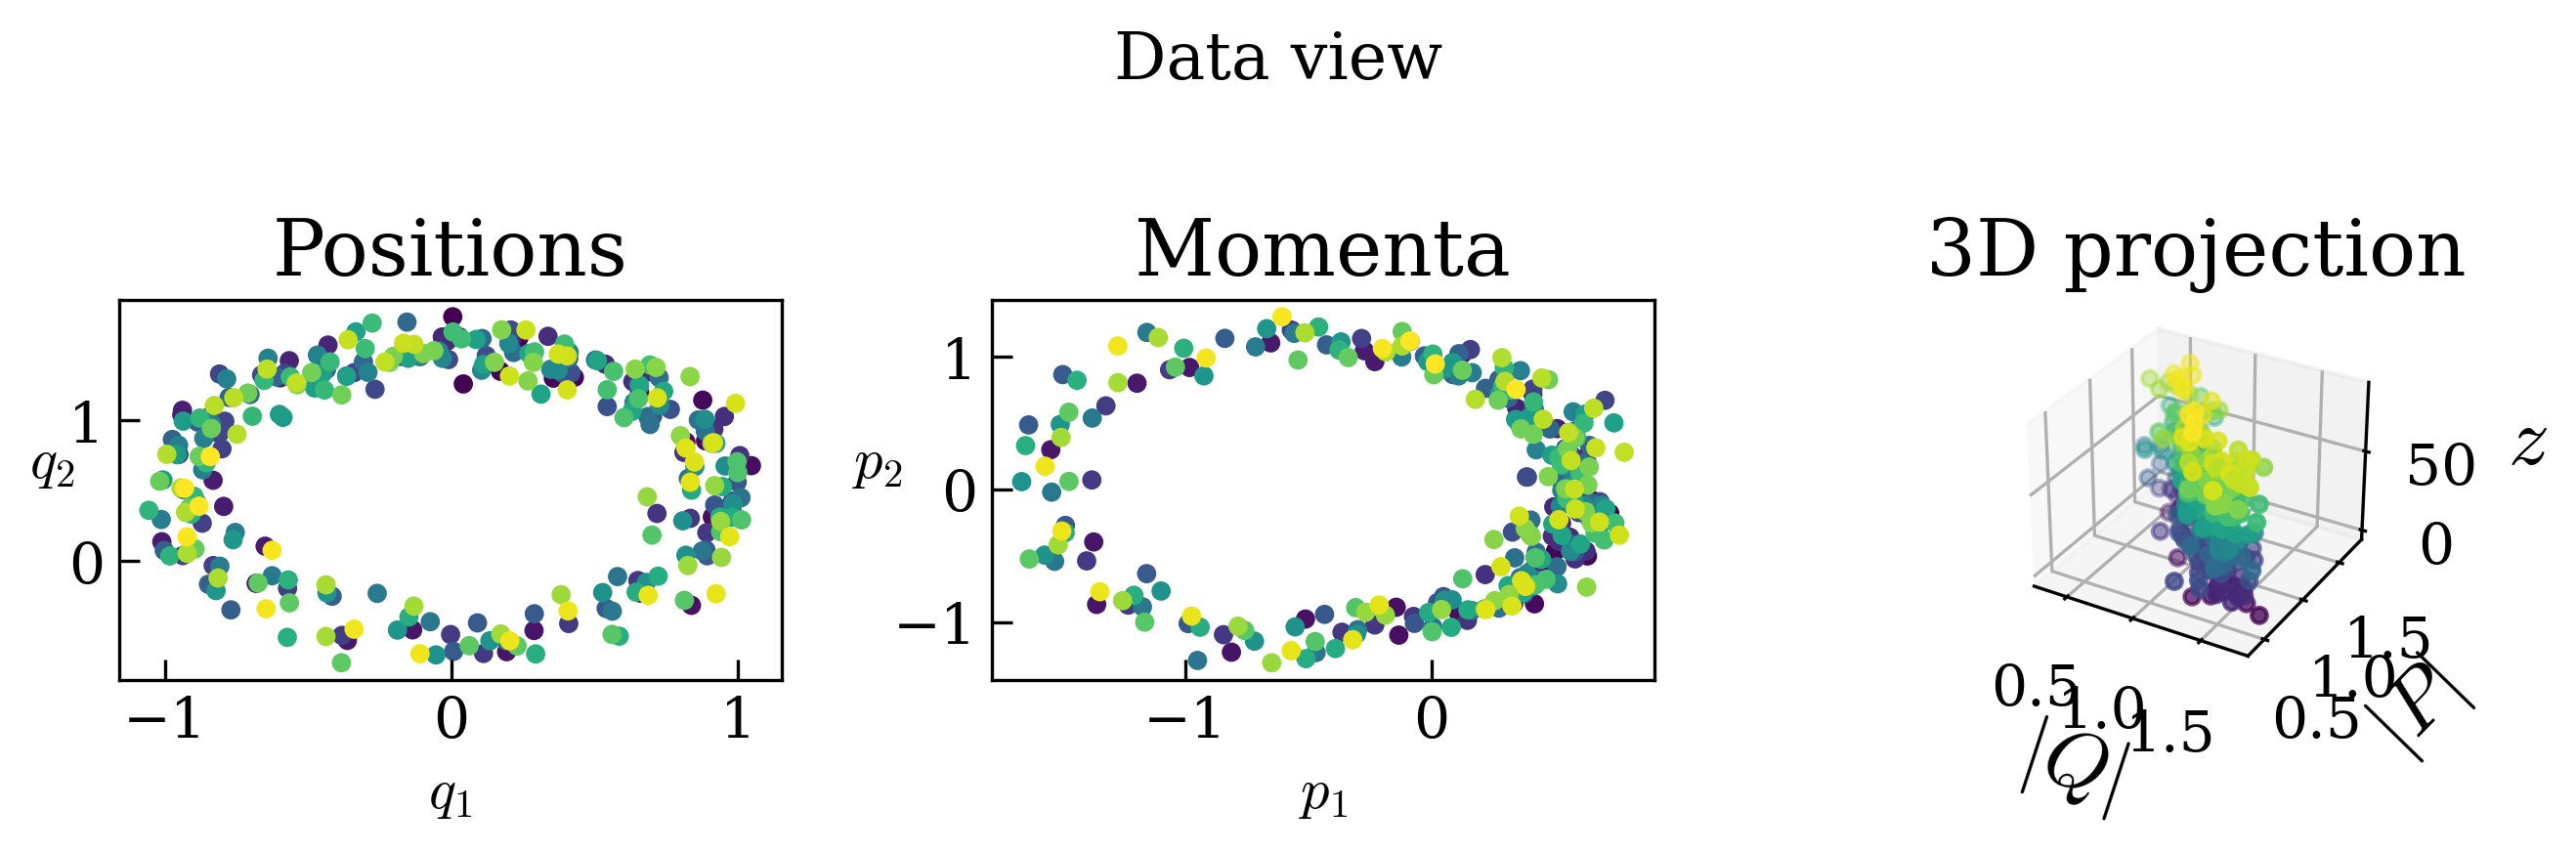

In [4]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
#field = get_field(gridsize=15)

#data = get_dataset(hamint=False, samples=1) 
# data of training and testing as a dictionary
# splitted by coordinates {'x'} and {'dx'}

#to fix initial conditions
ecc=0.4
# plot config
fig = plt.figure(figsize=(9, 3), facecolor='white', dpi=DPI)
fig.suptitle('Data view', fontsize=16)
init = init_ecc(ecc)
init = np.append(init,[0.])
x1, x2, y1, y2, z, dx1, dx2, dy1, dy2, dz, t = get_trajectory(hamint = False, radius=1, y0=init,timescale=5, noise_std=0.1)
# solution given by the numerical integrator and a noise
fig.add_subplot(1,3,1, frameon = True)
plt.scatter(x1,x2,c=t,s=14, label='data position')
#plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
#           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q_1$", fontsize=14)
plt.ylabel("$q_2$", rotation=0, fontsize=14)
plt.title("Positions")

fig.add_subplot(1,3,2, frameon=True)
plt.scatter(y1,y2,c=t, s=14, label='data momenta')
plt.xlabel("$p_1$", fontsize=14)
plt.ylabel("$p_2$", rotation=0, fontsize=14)
plt.title("Momenta")

ax=fig.add_subplot(1,3,3, projection='3d')
p=np.array([y1,y2]).squeeze().T
q=np.array([x1,x2]).squeeze().T
Q0=np.array([np.sqrt(np.dot(q[i,:],q[i,:])) for i in range(len(q))])
P0=np.array([np.sqrt(np.dot(p[i,:],p[i,:])) for i in range(len(p))])
ax.scatter3D(xs=Q0,ys=P0,zs=z,c=t,s=14)
ax.set_xlabel("$|Q|$")
ax.set_ylabel("$|P|$")
ax.set_zlabel("$z$")
plt.title("3D projection")

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/2bodyprob-task.png')

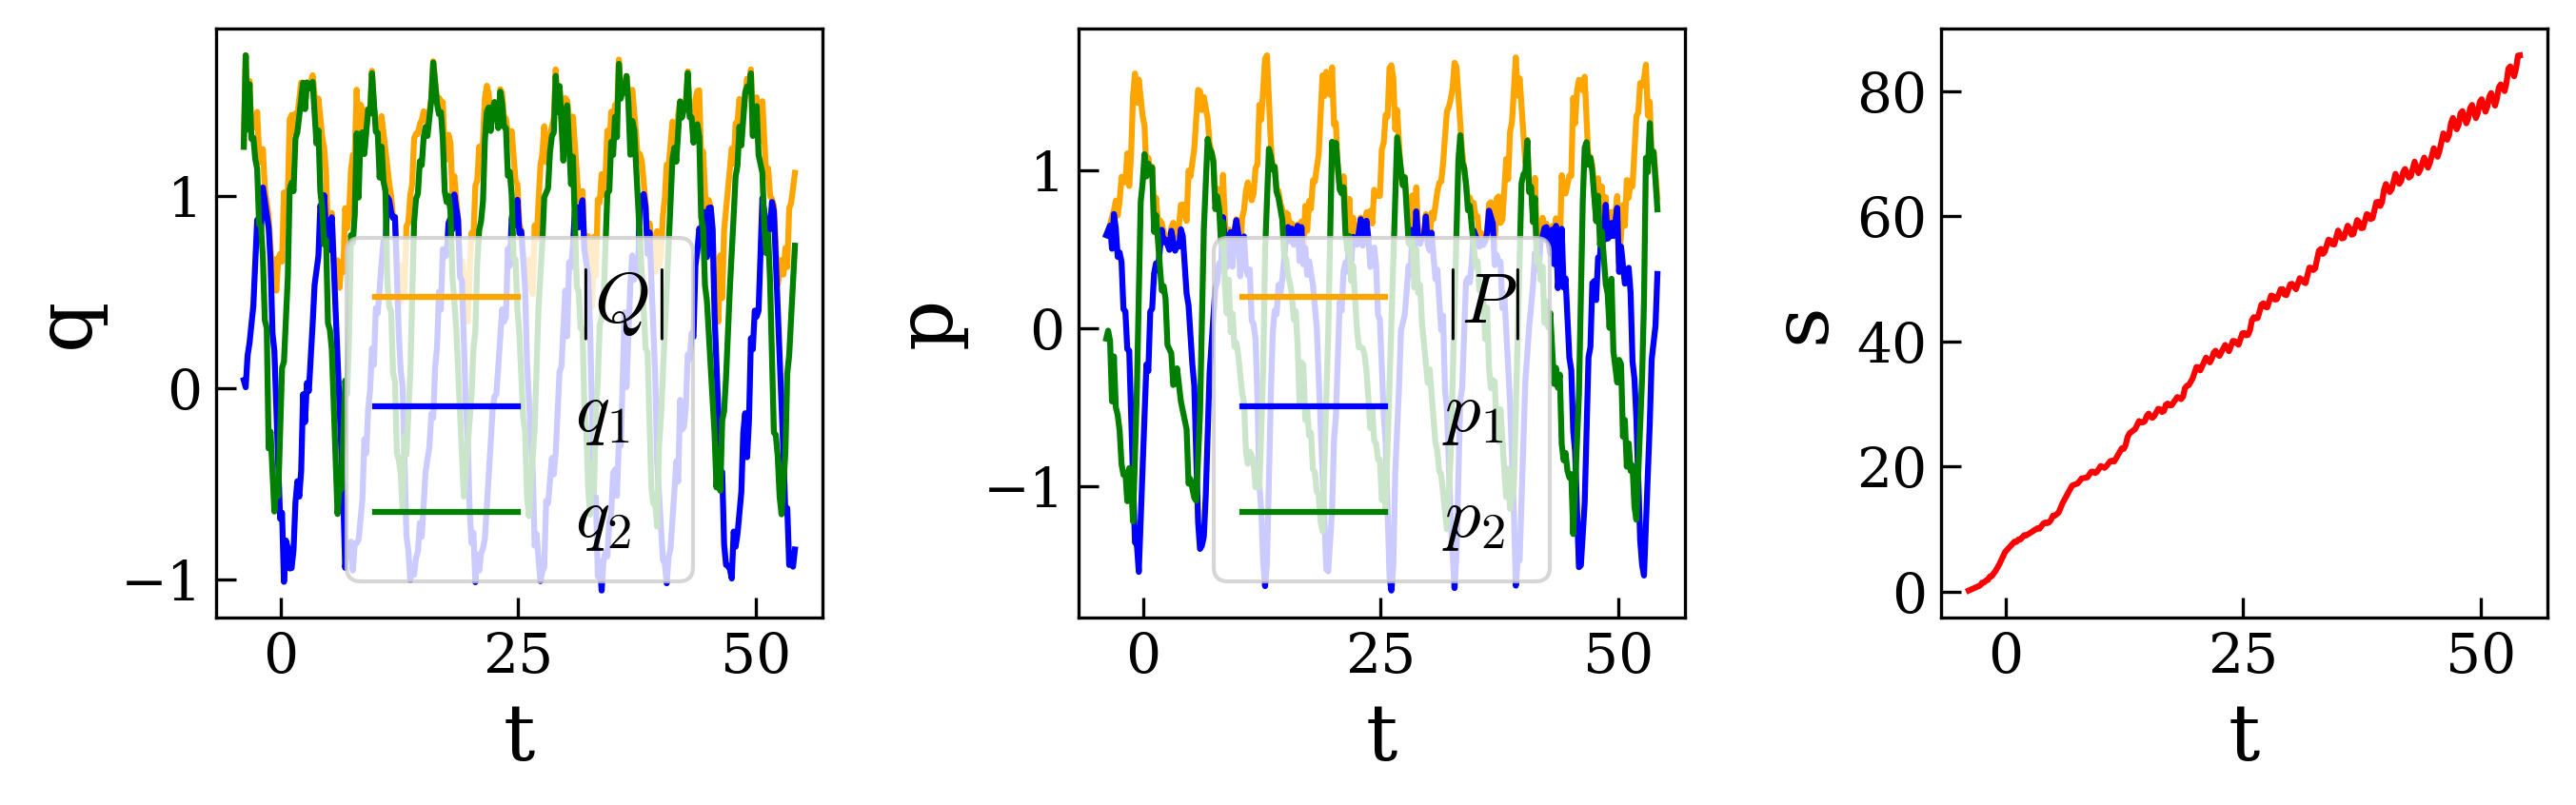

In [5]:
fig = plt.figure(figsize=(9.3,3.1), facecolor='white', dpi=DPI)
ax1=fig.add_subplot(1, 3, 1,frameon=True)
ax2=fig.add_subplot(1, 3, 2,frameon=True)
ax3=fig.add_subplot(1, 3, 3,frameon=True)
ax1.plot(t,Q0,color='orange',label='$|Q|$')
ax1.plot(t,x1,color='blue',label='$q_1$')
ax1.plot(t,x2,color='green',label='$q_2$')
ax1.legend()
ax1.set_xlabel('t')
ax1.set_ylabel('q',rotation=90)
ax2.plot(t,P0,color='orange',label='$|P|$')
ax2.plot(t,y1,color='blue',label='$p_1$')
ax2.plot(t,y2, color='green',label='$p_2$')
ax2.set_xlabel('t')
ax2.legend()
ax2.set_ylabel('p',rotation=90)
ax3.plot(t,z,color='red')
ax3.set_xlabel('t')
ax3.set_ylabel('s',rotation=90)
plt.tight_layout(); plt.show()

In [6]:
def get_model(args, baseline,hamint=False):
    output_dim = (args.input_dim-1) if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN_timedep(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    model_name = 'hamint-' + model_name if hamint else model_name
    path = "{}/2bodypert{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

In [7]:
def integrate_model(model, t_span, y0, **kwargs):
    def fun(t, np_x):
        tt1 = torch.tensor( [t], requires_grad=True, dtype=torch.float32)
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,5)
        dx = model.time_derivative(x=x,t=tt1).data.numpy().reshape(-1)
        return dx
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [8]:
base_model = get_model(args, baseline=True)
hnn_model = get_model(args, baseline=False)
hnn_model_ht = get_model(args, baseline=False, hamint=True)

# get their vector fields
#field = get_field(gridsize=args.gridsize)
#data = get_dataset(samples=1)
#base_field = get_vector_field(base_model, gridsize=args.gridsize)
#hnn_field = get_vector_field(hnn_model, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,6]
y0 = np.append(init_ecc(0.4),np.random.rand())
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)
hnn_ivp_ht = integrate_model(hnn_model_ht, t_span, y0, **kwargs)

In [9]:
x1,x2, y1,y2, z, dx1,dx2, dy1,dy2, dz, t = get_trajectory(ecc=0.4, radius=1, y0=y0,t_span=[0,6],timescale=1000,noise_std=0.)

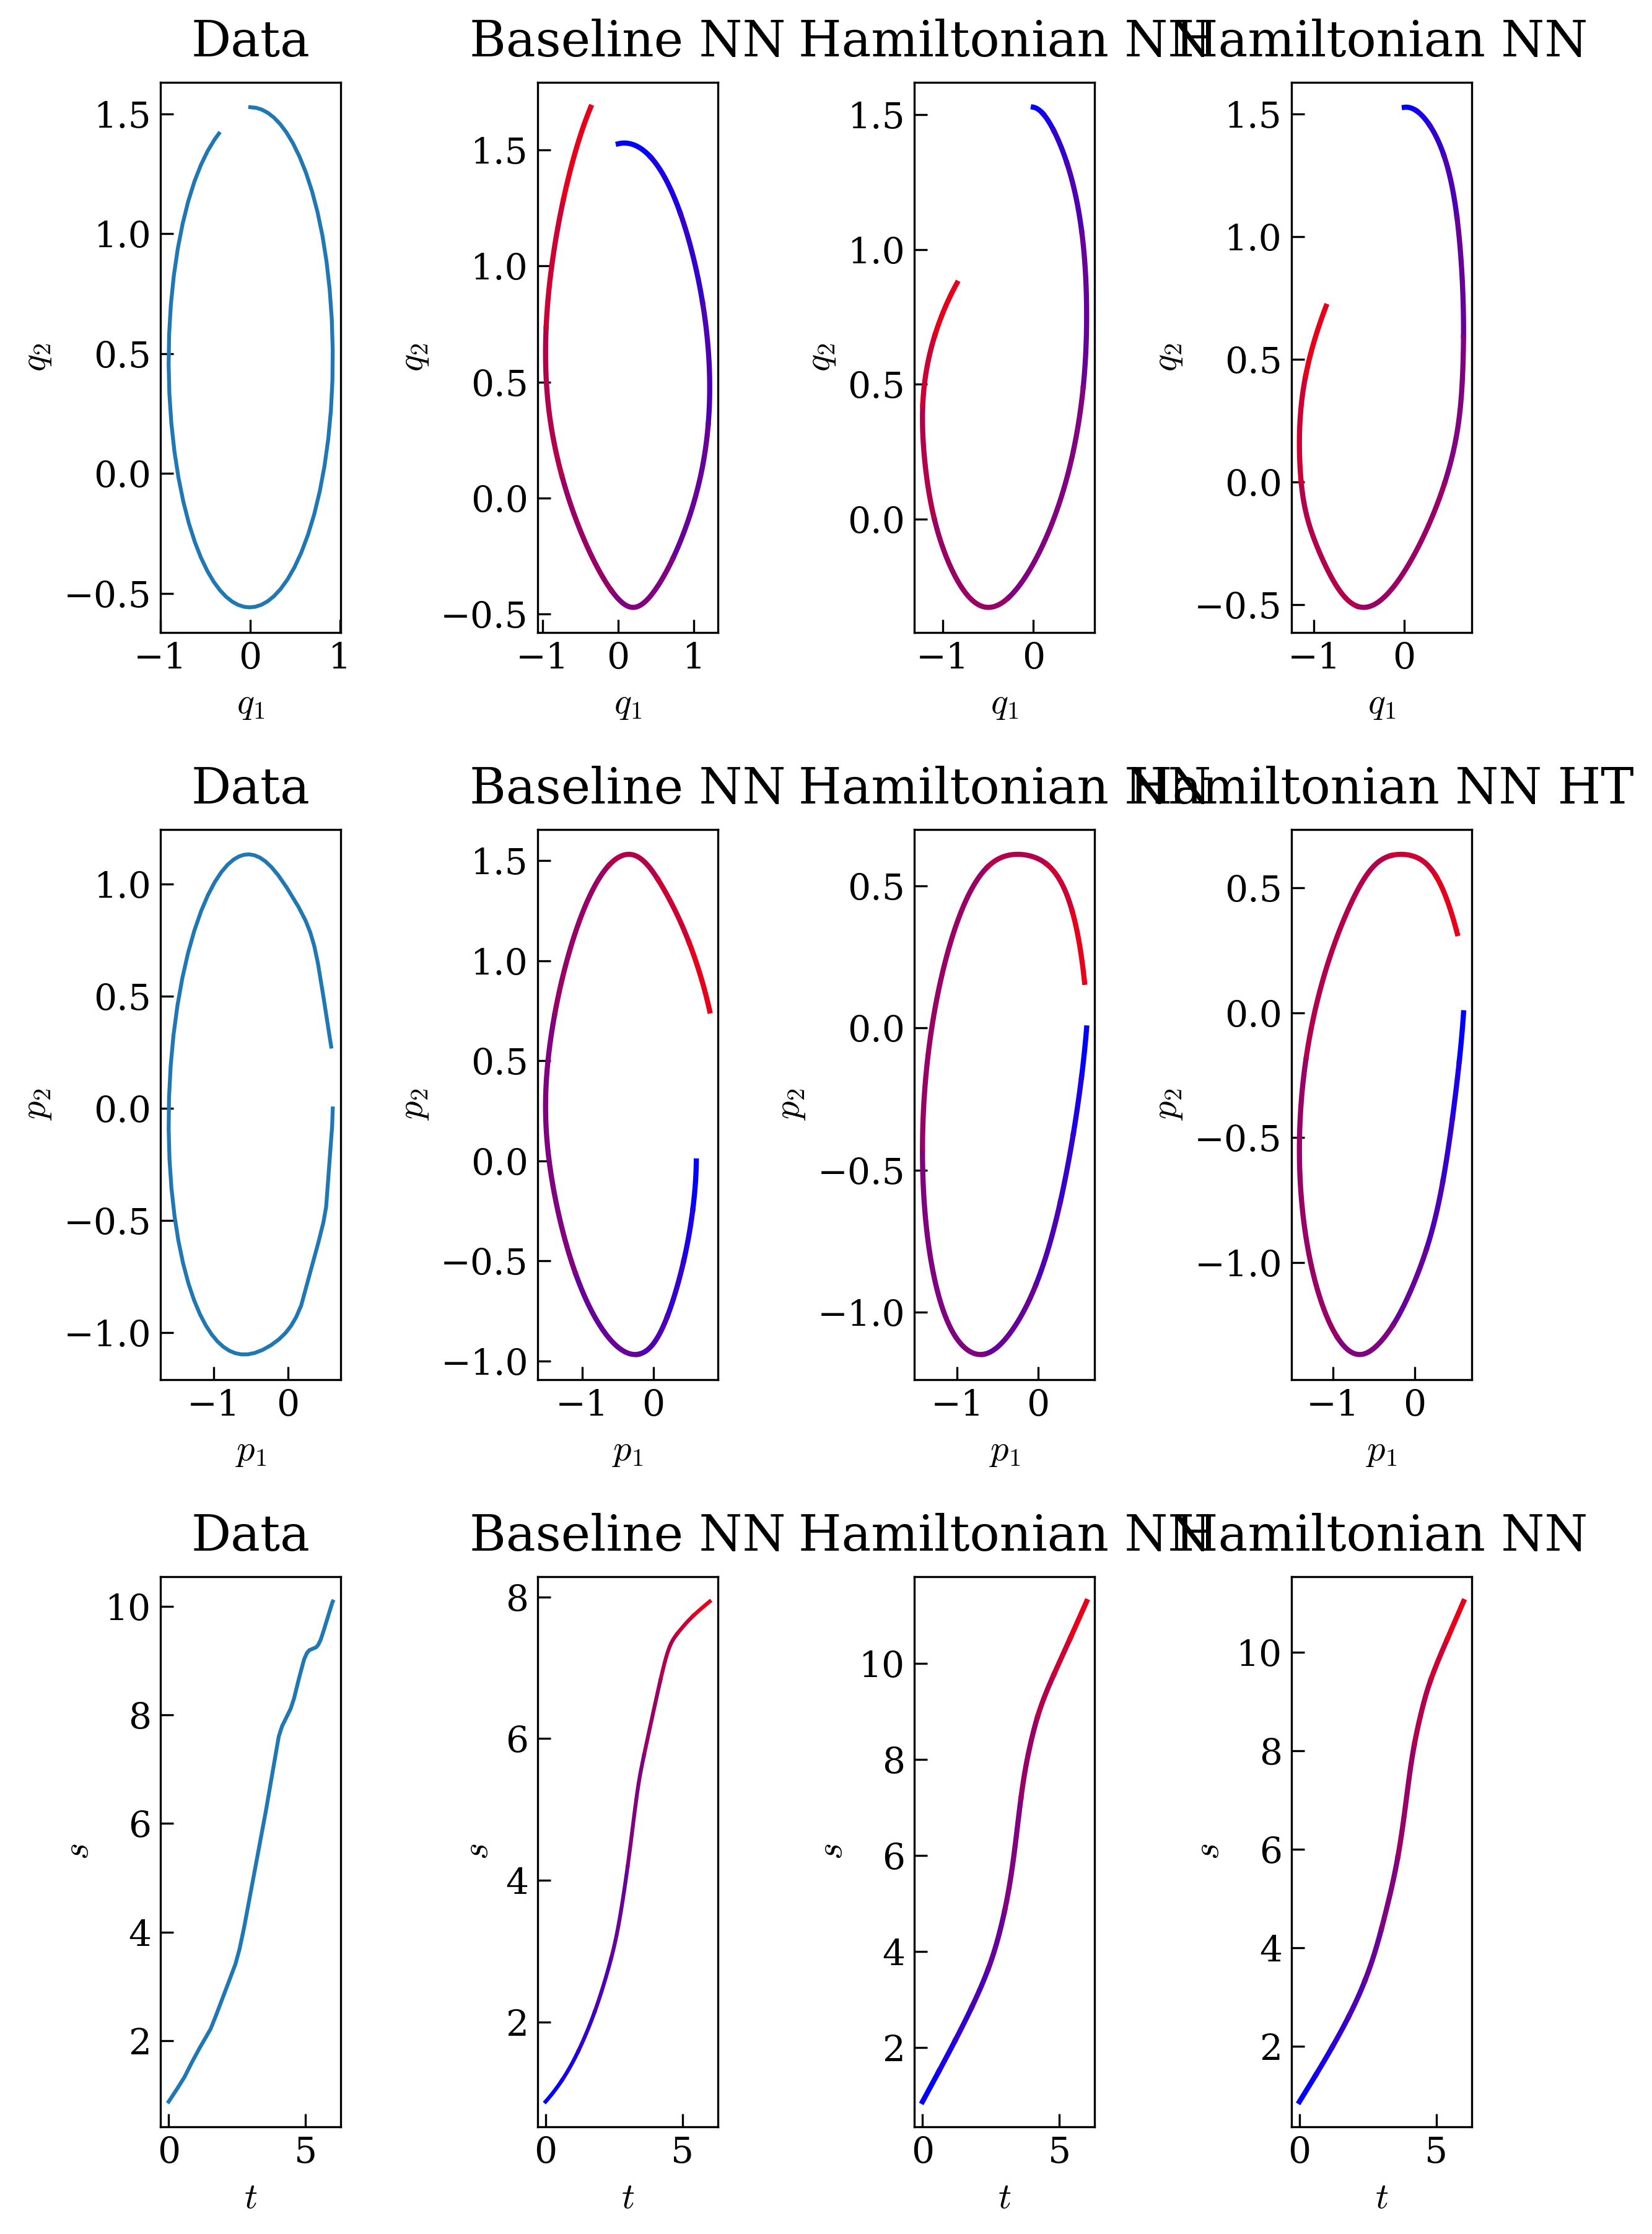

In [10]:
###### PLOT ######
fig = plt.figure(figsize=(8.3, 12.3), facecolor='white', dpi=DPI)

#plt.title("2 body system in reduced coordinates", pad=10)

# plot dynamics
fig.add_subplot(3, 4, 1, frameon=True)
#plt.xlim(-3,3)
#plt.ylim(-3,3)
#point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.plot(x1,x2, label='data')# s=22)

plt.xlabel("$q_1$", fontsize=14)
plt.ylabel("$q_2$", rotation=90, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(3, 4, 2, frameon=True)
#plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)
#plt.xlim(-3,3)
#plt.ylim(-3,3)  
plt.xlabel("$q_1$", fontsize=14)
plt.ylabel("$q_2$", rotation=90, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot HNN
fig.add_subplot(3, 4, 3, frameon=True)
#plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q_1$", fontsize=14)
plt.ylabel("$q_2$", rotation=90, fontsize=14)
#plt.xlim(-3,3)
#plt.ylim(-3,3)
plt.title("Hamiltonian NN", pad=10)
fig.add_subplot(3, 4, 4, frameon=True)
#plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp_ht['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$q_1$", fontsize=14)
plt.ylabel("$q_2$", rotation=90, fontsize=14)
#plt.xlim(-3,3)
#plt.ylim(-3,3)
plt.title("Hamiltonian NN", pad=10)

######################################################################################################################################


fig.add_subplot(3, 4, 5, frameon=True)
plt.plot(y1,y2, label='data')# s=22)

#plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$p_1$", fontsize=14)
plt.ylabel("$p_2$", rotation=90, fontsize=14)
#plt.xlim(-1.1,1.1)
#plt.ylim(-2,2)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(3, 4, 6, frameon=True)
#plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,2],l[:,3],color=color, linewidth=LINE_WIDTH)
#plt.xlim(-1.1,1.1)
#plt.ylim(-1,2)
plt.xlabel("$p_1$", fontsize=14)
plt.ylabel("$p_2$", rotation=90, fontsize=14)
plt.title("Baseline NN", pad=10)

# plot HNN
fig.add_subplot(3, 4, 7, frameon=True)
#plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,2],l[:,3],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$p_1$", fontsize=14)
plt.ylabel("$p_2$", rotation=90, fontsize=14)
#plt.xlim(-1.1,1.1)
#plt.ylim(-2,2)
plt.title("Hamiltonian NN", pad=10)

fig.add_subplot(3, 4, 8, frameon=True)
#plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp_ht['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,2],l[:,3],color=color, linewidth=LINE_WIDTH)

plt.xlabel("$p_1$", fontsize=14)
plt.ylabel("$p_2$", rotation=90, fontsize=14)
#plt.xlim(-1.1,1.1)
#plt.ylim(-2,2)
plt.title("Hamiltonian NN HT", pad=10)


#################################################################################################

fig.add_subplot(3, 4, 9, frameon=True)
#x1,x2, y1,y2, z, dx1,dx2, dy1,dy2, dz, t = get_trajectory(ecc=0.4, radius=1, y0=y0,timescale=5)
N = len(x1)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.plot(t,z, label='data')# s=22)

#plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.2,.2,.2))  
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$s$", rotation=90, fontsize=14)
plt.title("Data", pad=10)

# plot baseline
fig.add_subplot(3, 4, 10, frameon=True)
#plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    lenght=len(l[:,1])
    plt.plot(base_ivp['t'][lenght*i:lenght*(i+1)],l[:,4], color=color)
#plt.xlim(-1.1,1.1)
#plt.ylim(-1,2)  
plt.xlabel("$t$", fontsize=14)
plt.ylabel("$s$", rotation=90, fontsize=14)
plt.title("Baseline NN", pad=10)

#plot HNN
fig.add_subplot(3, 4, 11, frameon=True)
#plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    lenght=len(l[:,1])
    plt.plot(hnn_ivp['t'][lenght*i:lenght*(i+1)],l[:,4], color=color, linewidth=LINE_WIDTH)

plt.xlabel("$t$", fontsize=14)
plt.ylabel("$s$", rotation=90, fontsize=14)
#plt.xlim(-1.1,1.1)
#plt.ylim(-0.5,2)
plt.title("Hamiltonian NN", pad=10)

fig.add_subplot(3, 4, 12, frameon=True)
#plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
#        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH, color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp_ht['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    lenght=len(l[:,1])
    plt.plot(hnn_ivp_ht['t'][lenght*i:lenght*(i+1)],l[:,4], color=color, linewidth=LINE_WIDTH)

plt.xlabel("$t$", fontsize=14)
plt.ylabel("$s$", rotation=90, fontsize=14)
#plt.xlim(-1.1,1.1)
#plt.ylim(-0.5,2)
plt.title("Hamiltonian NN", pad=10)

plt.tight_layout() ; plt.show()
#fig.savefig('{}/spring{}.{}'.format(args.fig_dir, RK4, FORMAT))

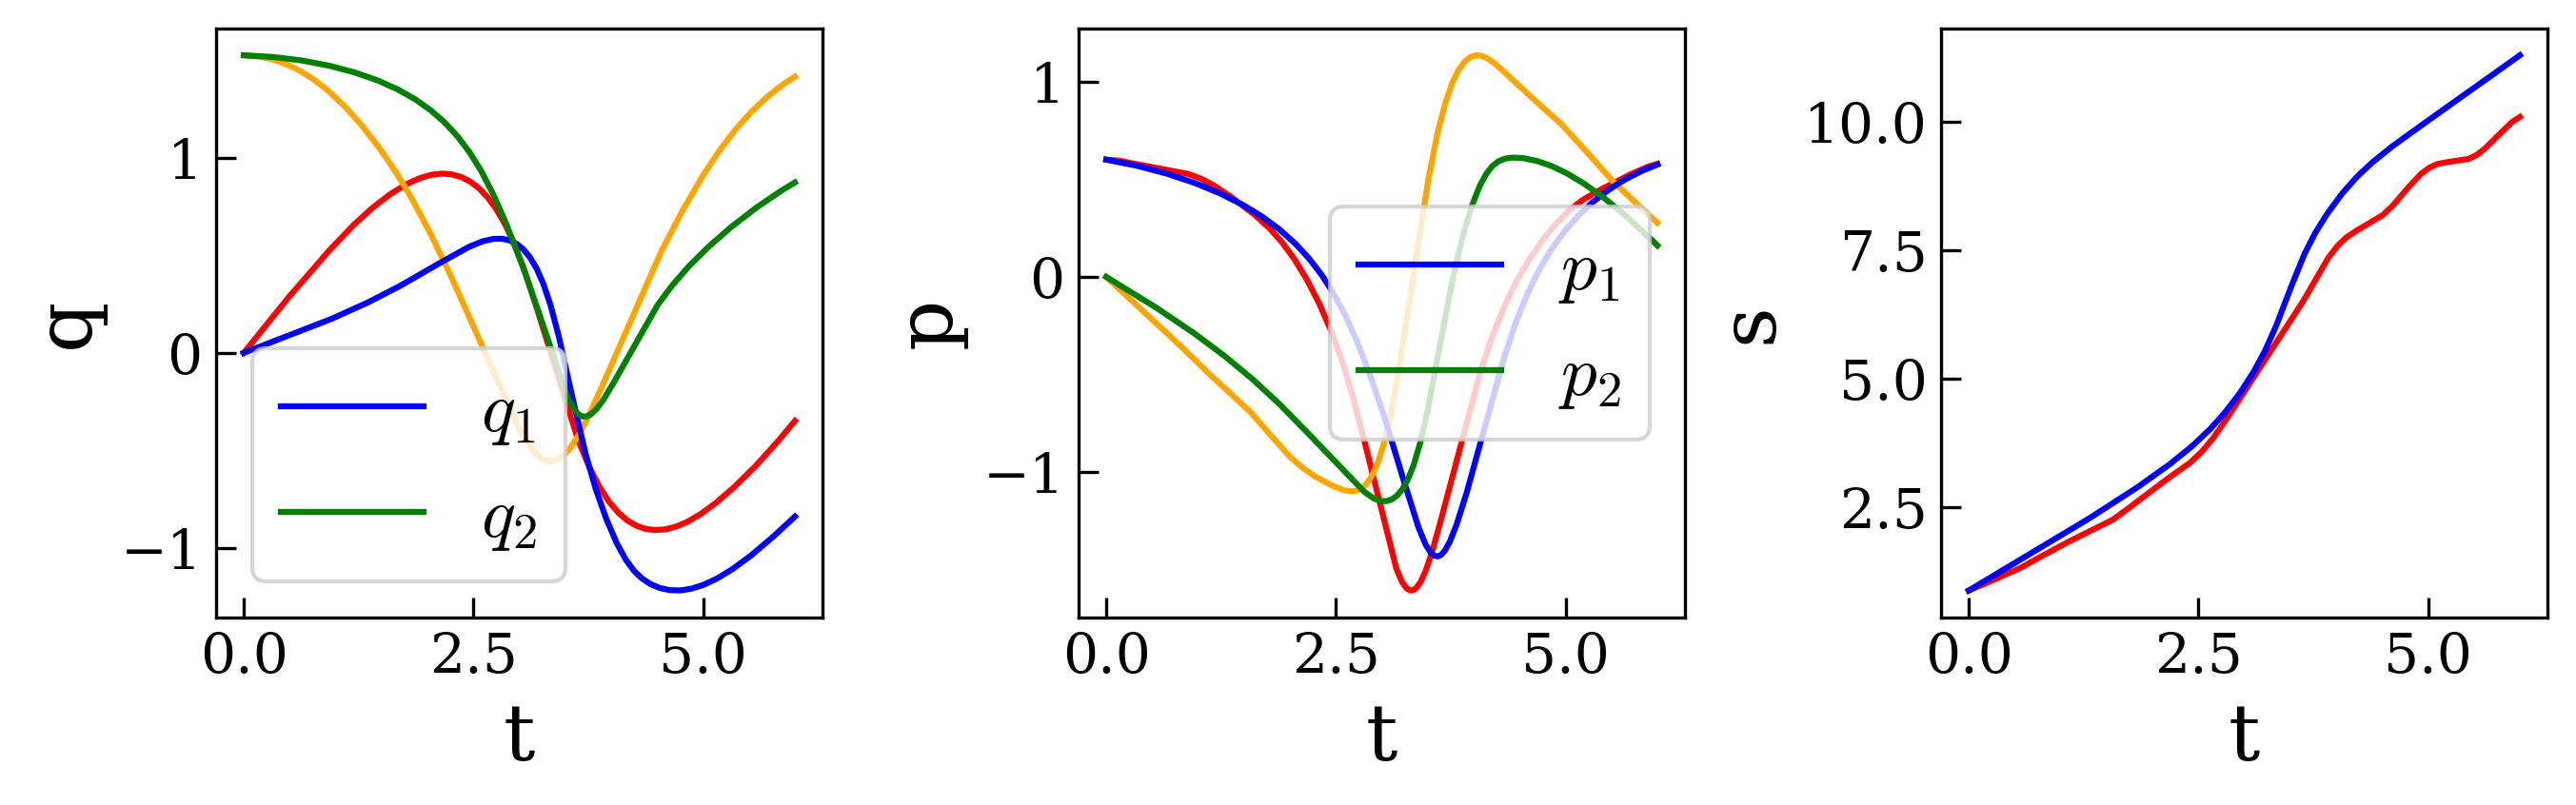

In [11]:
fig = plt.figure(figsize=(9.3,3.1), facecolor='white', dpi=DPI)
ax1=fig.add_subplot(1, 3, 1,frameon=True)
ax2=fig.add_subplot(1, 3, 2,frameon=True)
ax3=fig.add_subplot(1, 3, 3,frameon=True)
ax1.plot(t,x1,color='red')
ax1.plot(t,x2,color='orange')
ax1.plot(hnn_ivp['t'],hnn_ivp['y'][0,:],color='blue',label='$q_1$')
ax1.plot(hnn_ivp['t'],hnn_ivp['y'][1,:],color='green',label='$q_2$')
ax1.legend()
ax1.set_xlabel('t')
ax1.set_ylabel('q',rotation=90)
ax2.plot(t,y1,color='red')
ax2.plot(t,y2,color='orange')
ax2.plot(hnn_ivp['t'],hnn_ivp['y'][2,:],color='blue',label='$p_1$')
ax2.plot(hnn_ivp['t'],hnn_ivp['y'][3,:], color='green',label='$p_2$')
ax2.set_xlabel('t')
ax2.legend()
ax2.set_ylabel('p',rotation=90)
ax3.plot(t,z,color='red')
ax3.plot(hnn_ivp['t'],hnn_ivp['y'][4,:],color='blue')
ax3.set_xlabel('t')
ax3.set_ylabel('s',rotation=90)
plt.tight_layout(); plt.show()

In [12]:
def integrate_models(x0=np.append(init_ecc(0.4),0), t_span=[0,10], t_eval=None, noise_std=0.1):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T
    
    # rescale time to compensate for noise effects, as described in appendix
    t_span[1] *= 1 + .9*noise_std
    t_eval *= 1 + .9*noise_std

    # integrate along baseline vector field
    base_path = integrate_model(base_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    
    #integrate along HNN vector field
    hnn_path_ht = integrate_model(hnn_model_ht, t_span, x0, **kwargs)
    hnn_x_ht = hnn_path_ht['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    return true_x, base_x, hnn_x, hnn_x_ht

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

In [13]:
def base_energy(x) :
        vec = base_model(torch.Tensor(x)).detach().numpy().squeeze()
        eta=np.zeros(vec.shape)
        print(vec.shape)
        print(eta.shape)
        print(x.shape)
        eta[:,:2]=-x[:,2:4]
        eta[:,4]=1
        en=np.einsum('ij,ij->i',vec,eta)
        return en

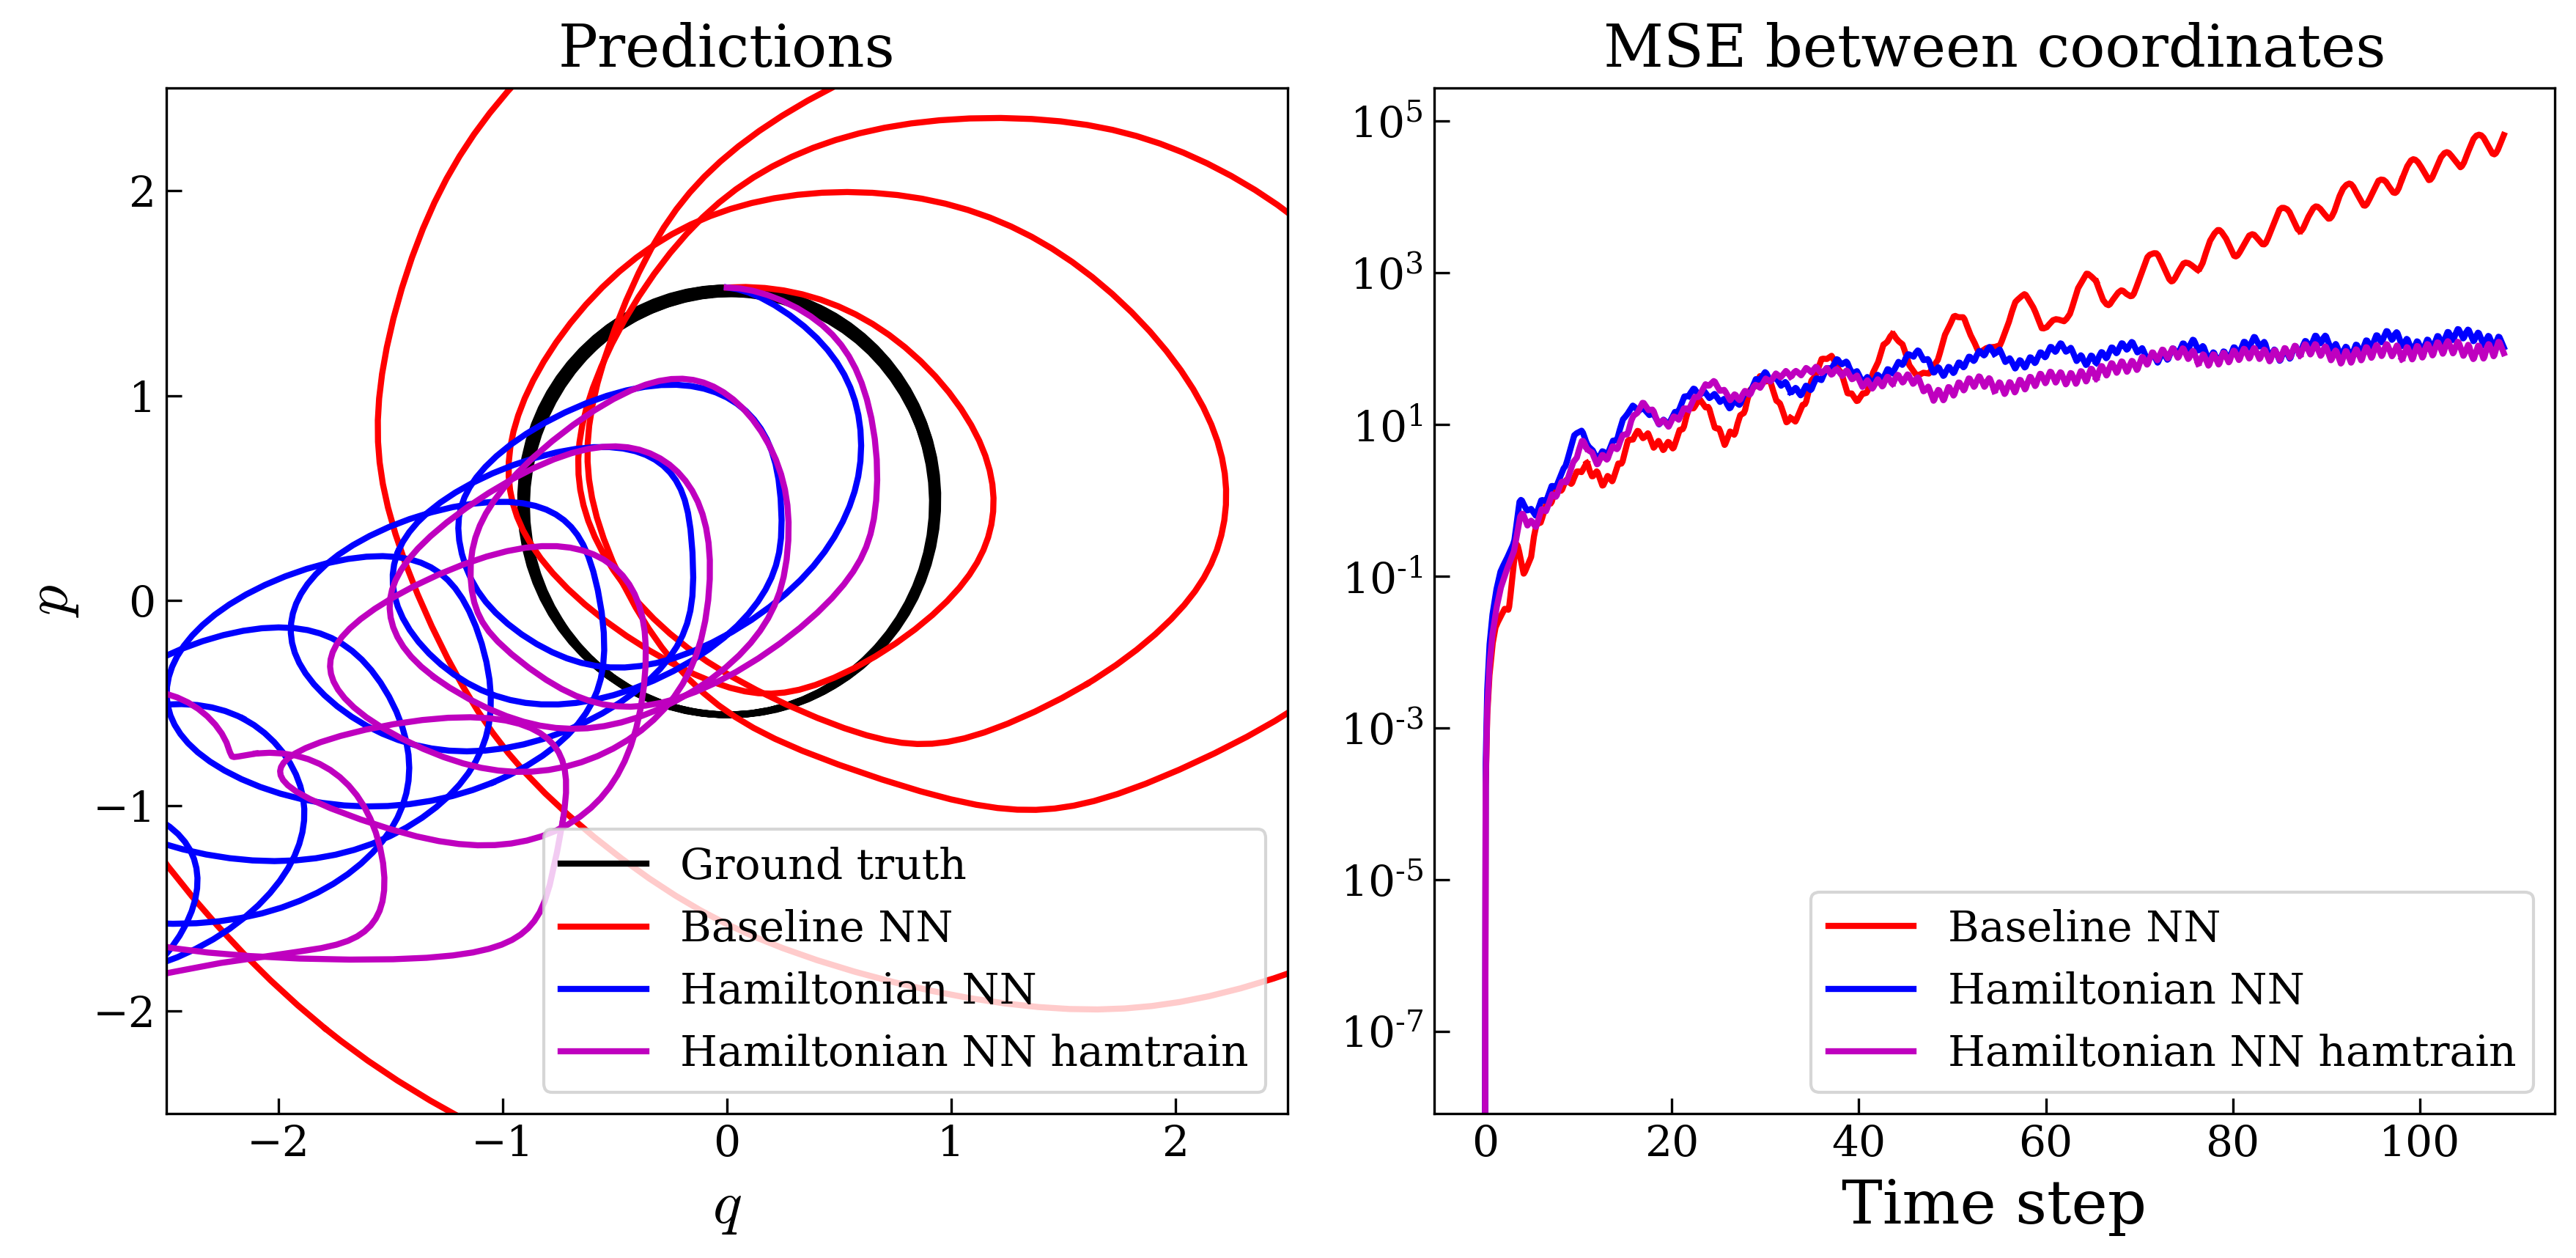

In [21]:


#spans=np.arange(8.5, 9.5,0.5)
spans=[9.]
fig = plt.figure(figsize=[12,6], dpi=DPI)
t_span=[0,100]
t_eval = np.linspace(t_span[0], t_span[1], 100000)
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
#ax3=plt.subplot(1,2,3)
#ax4=plt.subplot(2,4,4)
#ax5=plt.subplot(2,4,5)
#ax6=plt.subplot(2,4,6)
#ax7=plt.subplot(2,4,7)
#ax8=plt.subplot(2,4,8)

for sigma in spans:
    x0=np.append(init_ecc(0.4),0)

    # integration
    true_x, base_x, hnn_x, hnn_x_ht = integrate_models(x0=x0, t_span=t_span, t_eval=t_eval)

    # plotting
    tpad = 7
    ax1.set_title("Predictions", pad=tpad); ax1.set_xlabel('$q$') ; ax1.set_ylabel('$p$')
    ax1.plot(true_x[:,0], true_x[:,1], 'k-', label='Ground truth', linewidth=2)
    ax1.plot(base_x[:,0], base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
    ax1.plot(hnn_x[:,0], hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
    ax1.plot(hnn_x_ht[:,0], hnn_x_ht[:,1], 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
    ax1.set_xlim(-2.5, 2.5) ; ax1.set_ylim(-2.5,2.5)
    ax1.legend(fontsize=14)
    
    ax2.set_title("MSE between coordinates", pad=tpad) ; ax2.set_xlabel('Time step')
    ax2.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
    ax2.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
    ax2.plot(t_eval, ((true_x-hnn_x_ht)**2).mean(-1), 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
    ax2.legend(fontsize=14)
    ax2.set_yscale('log')

    
#     ax3.set_title("Predictions s", pad=tpad) ; ax4.set_xlabel('$t$') ; ax4.set_ylabel('$s$')
#     ax3.plot(t_eval, true_x[:,2], 'k-', label='Ground truth', linewidth=2)
#     ax3.plot(t_eval, base_x[:,2], 'r-', label='Baseline NN', linewidth=2)
#     ax3.plot(t_eval, hnn_x[:,2], 'b-', label='Hamiltonian NN', linewidth=2)
#     ax3.plot(t_eval, hnn_x_ht[:,2], 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
#     ax3.set_ylim(-10,10)
#     ax3.legend(fontsize=7)

#     ax4.set_title("Predictions $q_1$", pad=tpad) ; ax2.set_xlabel('$t$') ; ax2.set_ylabel('$q$')
#     ax4.plot(t_eval, true_x[:,0], 'k-', label='Ground truth', linewidth=2)
#     ax4.plot(t_eval, base_x[:,0], 'r-', label='Baseline NN', linewidth=2)
#     ax4.plot(t_eval, hnn_x[:,0], 'b-', label='Hamiltonian NN', linewidth=2)
#     ax4.plot(t_eval, hnn_x_ht[:,0], 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
#     ax4.set_ylim(-2.5,2.5)
#     ax4.legend(fontsize=7)  
    
#     ax5.set_title("Predictions $q_2$", pad=tpad) ; ax3.set_xlabel('$t$') ; ax3.set_ylabel('$p$')
#     ax5.plot(t_eval, true_x[:,1], 'k-', label='Ground truth', linewidth=2)
#     ax5.plot(t_eval, base_x[:,1], 'r-', label='Baseline NN', linewidth=2)
#     ax5.plot(t_eval, hnn_x[:,1], 'b-', label='Hamiltonian NN', linewidth=2)
#     ax5.plot(t_eval, hnn_x_ht[:,1], 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
#     ax5.set_ylim(-10,10)
#     ax5.legend(fontsize=7)

#     ax6.set_title("Total HNN-energy", pad=tpad)
#     ax6.set_xlabel('t')
#     true_x_1=np.append(t_eval.reshape(len(t_eval),1),true_x,axis=-1)
#     base_x_1=np.append(t_eval.reshape(len(t_eval),1),base_x,axis=-1)
#     hnn_x_1=np.append(t_eval.reshape(len(t_eval),1),hnn_x,axis=-1)
#     hnn_x_ht_1=np.append(t_eval.reshape(len(t_eval),1),hnn_x_ht,axis=-1)
#     #true_hq = hnn_model(torch.Tensor(true_x_1))[1].detach().numpy().squeeze()
#     true_hq = np.stack([hamiltonian_fn(c) for c in true_x_1]).squeeze()
#     base_hq = base_energy(base_x_1)
#     hnn_hq = hnn_model(torch.Tensor(hnn_x_1))[1].detach().numpy().squeeze()
#     hnn_hq_ht = hnn_model_ht(torch.Tensor(hnn_x_ht_1))[1].detach().numpy().squeeze()
#     ax6.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
#     ax6.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
#     ax6.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
#     ax6.plot(t_eval, hnn_hq_ht, 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
#     ax6.legend(fontsize=7)

#     ax7.set_title("Hamiltonian", pad=tpad)
#     ax7.set_xlabel('t')
#     ax7.plot(t_eval, true_hq, 'k-', label='Ground truth', linewidth=2)
#     ax7.plot(t_eval, base_hq, 'r-', label='Baseline NN', linewidth=2)
#     ax7.plot(t_eval, hnn_hq, 'b-', label='Hamiltonian NN', linewidth=2)
#     ax7.plot(t_eval, hnn_hq_ht, 'm-', label='Hamiltonian NN hamtrain', linewidth=2)
#     ax7.legend(fontsize=7)
    
#     ax8.set_title("Error Constant of Motion", pad=tpad) ; ax8.set_xlabel('Time step')
#     #true_e = np.stack([k2_fn(c) for c in true_x])
#     #base_e = np.stack([k2_fn(c) for c in base_x])
#     #hnn_e = np.stack([k2_fn(c) for c in hnn_x])
#     #ax8.plot(t_eval, true_e, 'k-', label='Ground truth', linewidth=2)
#     #ax8.plot(t_eval, base_e, 'r-', label='Baseline NN', linewidth=2)
#     #ax8.plot(t_eval, hnn_e, 'b-', label='Hamiltonian NN', linewidth=2)
#     ax8.legend(fontsize=7)

plt.tight_layout()
plt.show()
#fig.savefig('{}/quad-osc{}.{}'.format(args.fig_dir, RK4, FORMAT))